In [178]:
import numpy as np
from utils import *
import pandas as pd
from sklearn.metrics import confusion_matrix

data = pd.read_table("data/trec_crowd.txt", header=None)
truth = pd.read_table("data/trec_truth.txt", header=None)


In [179]:
import matplotlib.pyplot as plt


In [180]:
truth = truth.drop_duplicates()

In [181]:
n, m, k = np.max(np.array(data), axis=0)
print(n, m, k)


19033 762 2


In [182]:
labels = transform_data(data)


In [183]:
labels

array([[ 0,  0,  0, ..., -1, -1, -1],
       [ 1,  1,  0, ..., -1, -1, -1],
       [ 1,  1,  1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int64)

In [184]:
# proportion of missing values
np.mean(labels==-1)

0.9939058049887934

In [185]:
groups = np.array([i % 3 for i in range(m)])


In [186]:
C_estimated = get_confusion_matrix(k, labels, groups=groups, sym=False)


LinAlgError: Singular matrix

In [153]:
i = 10
truth_new = truth[truth[0].isin(data[data[1] == i+1][0])]
pred_new = data[data[1] == i+1][data[data[1] == i+1][0].isin(truth_new[0])]


In [154]:
C = confusion_matrix(pred_new[2], truth_new[1])


In [155]:
np.round(C / np.sum(C, axis=0)[np.newaxis, :], 5)


array([[0.94737, 0.11905],
       [0.05263, 0.88095]])

In [156]:
np.round(C_estimated[i], 5)


array([[0.868  , 0.21272],
       [0.132  , 0.78728]])

In [157]:
def get_true_confusion_matrix(data, truth, normalize=True):
    truth = truth.drop_duplicates()
    n, m, k = np.max(np.array(data), axis=0)
    C = np.zeros((m, k, k))
    for i in range(m):
        truth_new = truth[truth[0].isin(data[data[1] == i+1][0])]
        pred_new = data[data[1] == i +
                        1][data[data[1] == i+1][0].isin(truth_new[0])]
        Ci = confusion_matrix(pred_new[2], truth_new[1], labels=[
                              i+1 for i in range(k)])
        if normalize:
            Ci = Ci.astype(float)
            colsums = np.sum(Ci, axis=0)
            Ci[:, colsums != 0] /= colsums[np.newaxis, colsums != 0]
        C[i, :, :] = Ci
    return C


In [158]:
def confusion_matrix_loss(C_estimated,C_true):
    return np.mean((C_estimated-C_true)**2)


In [159]:
def get_confusion_matrix(k, labels, groups=None, sym=True, cutoff=1e-7, L=20, N=100, seed=None):
    m, n = labels.shape
    if groups is None:
        if seed is not None:
            np.random.seed(seed)
        groups = np.random.randint(3, size=m)
    Zg = get_Zg(k, labels, groups)
    M2s, M3s = get_M(Zg)
    Cc = np.zeros((3, k, k))
    W = np.zeros((3, k, k))
    for g, (M2, M3) in enumerate(zip(M2s, M3s)):
        Q = get_whiten(M2, sym)
        M3_whiten = whiten_tensor(M3, Q)
        values, vectors = robust_tensor_power(M3_whiten, L, N, sym)
        w = values**-2
        mu = np.linalg.inv(Q.T)@vectors@np.diag(values)
        best = np.argmax(mu, axis=0)
        for h in range(k):
            Cc[g, :, best[h]] = mu[:, h]
            W[g, best[h], best[h]] = w[h]
    W = np.mean(W, axis=0)
    C = np.zeros((m, k, k))
    for i in range(m):
        Ca = (np.sum(Cc, axis=0)-Cc[groups[i], :, :])/2
        Za = (np.sum(Zg, axis=0)-Zg[groups[i], :, :])/2
        E = np.zeros((k, k))
        for j in range(n):
            if labels[i, j] != -1:
                E[labels[i, j], :] += Za[j, :]
        E /= n
        Ci = E@np.linalg.inv(W@Ca.T)
        if cutoff:
            Ci[Ci < cutoff] = cutoff
        colsums = np.sum(Ci, axis=0)
        Ci /= colsums[np.newaxis, :]
        C[i, :, :] = Ci
    return C

In [160]:
truth_new[1].drop_duplicates().sort_values()

20    1
25    2
Name: 1, dtype: int64

In [161]:
C_true = get_true_confusion_matrix(data, truth)


In [162]:
confusion_matrix_loss(get_confusion_matrix(
    k, labels, groups=groups, sym=False), C_true)


0.010581730126978486

In [163]:
# symmetric or not
iternum = 500
sym_losses = np.zeros(iternum)
asym_losses = np.zeros(iternum)
for i in range(iternum):
    sym_losses[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=True), C_true)
    asym_losses[i] = confusion_matrix_loss(get_confusion_matrix(
        k, labels, sym=False), C_true)


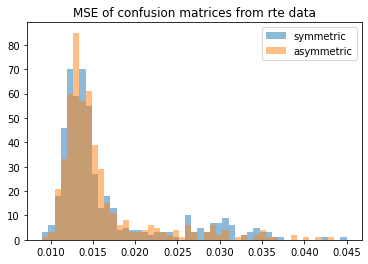

In [177]:
bins = np.linspace(0.009, 0.045, 50)
plt.hist(sym_losses,bins, alpha=0.5, label='symmetric')
plt.hist(asym_losses, bins, alpha=0.5, label='asymmetric')
plt.title("MSE of confusion matrices from trec data")
plt.legend(loc='upper right')
plt.savefig("pic/trec_symmetry.png",dpi=300)
plt.show()

From the plot we can see if we symmetricalize the matrices and tensors, the MSE of the confusion matrices can be reduced.